In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: autogenes 1.0.4 has a non-standard dependency specifier matplotlib>=3.0.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of autogenes or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from datasets import load_dataset
from tqdm import tqdm


In [2]:
dataset = load_dataset("squad_v2")

In [3]:
dataset["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})


In [5]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [6]:
show_random_elements(dataset["train"])

,id,title,context,question,answers
0,572830622ca10214002da032,Annelid,"Charles Darwin's book The Formation of Vegetable Mould through the Action of Worms (1881) presented the first scientific analysis of earthworms' contributions to soil fertility. Some burrow while others live entirely on the surface, generally in moist leaf litter. The burrowers loosen the soil so that oxygen and water can penetrate it, and both surface and burrowing worms help to produce soil by mixing organic and mineral matter, by accelerating the decomposition of organic matter and thus making it more quickly available to other organisms, and by concentrating minerals and converting them to forms that plants can use more easily. Earthworms are also important prey for birds ranging in size from robins to storks, and for mammals ranging from shrews to badgers, and in some cases conserving earthworms may be essential for conserving endangered birds.",Who published a book about worms in 1881?,"{'text': ['Charles Darwin'], 'answer_start': [0]}"
1,56d538bc2593cc1400307aef,2008_Sichuan_earthquake,"Reginald DesRoches, a professor of civil and environmental engineering at Georgia Tech, pointed out that the massive damage of properties and houses in the earthquake area was because China did not create an adequate seismic design code until after the devastating 1976 Tangshan earthquake. DesRoches said: ""If the buildings were older and built prior to that 1976 earthquake, chances are they weren't built for adequate earthquake forces.""",What catastrophe inspired them to make a building design code/,"{'text': ['Tangshan earthquake'], 'answer_start': [270]}"
2,5ace841032bba1001ae4a928,Madrasa,"In 2004, madaris were mainstreamed in 16 Regions nationwide, primarily in Muslim-majority areas in Mindanao under the auspices of the Department of Education (DepEd). The DepEd adopted Department Order No. 51, which instituted Arabic-language and Islamic Values instruction for Muslim children in state schools, and authorised implementation of the Standard Madrasa Curriculum (SMC) in private-run madaris. While there are state-recognised Islamic schools, such as Ibn Siena Integrated School in the Islamic City of Marawi, Sarang Bangun LC in Zamboanga and SMIE in Jolo, their Islamic studies programmes initially varied in application and content.",What curriculum is used in public madaris in Mindanao?,"{'text': [], 'answer_start': []}"
3,56db2df9e7c41114004b4edf,American_Idol,"23-year-old Candice Glover won the season with Kree Harrison taking the runner-up spot. Glover is the first female to win American Idol since Jordin Sparks. Glover released ""I Am Beautiful"" as a single while Harrison released ""All Cried Out"" immediately after the show. Glover sold poorly with her debut album, and this is also the first season that the runner-up was not signed by a music label.",This is the first season when what did not happen to the first runner up?,"{'text': ['not signed by a music label'], 'answer_start': [368]}"
4,5731036405b4da19006bccda,Immaculate_Conception,"The report ""Mary: Faith and Hope in Christ"", by the Anglican-Roman Catholic International Commission, concluded that the teaching about Mary in the two definitions of the Assumption and the Immaculate Conception can be said to be consonant with the teaching of the Scriptures and the ancient common traditions. But the report expressed concerns that the Roman Catholic dogmatic definitions of these concepts implies them to be ""revealed by God"", stating: ""The question arises for Anglicans, however, as to whether these doctrines concerning Mary are revealed by God in a way which must be held by believers as a matter of faith.""",What was written by the a all inclusive group convened by the holy church centered in Rome ?,"{'text': ['Anglican-Roman Catholic International Commission'], 'answer_start': [52]}"


In [7]:
def preprocess_data(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    max_length = 512  # Adjust based on your model's capacity

    questions = [q.strip() for q in examples['question']]
    contexts = [c.strip() for c in examples['context']]
    answers = examples['answers']

    inputs = tokenizer(questions, contexts, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
    start_positions = []
    end_positions = []

    for i, answer in enumerate(answers):
        start_position = answer['answer_start'][0] if answer['answer_start'] else 0
        end_position = start_position + len(answer['text'][0]) if answer['text'] else 0

        start_positions.append(start_position)
        end_positions.append(end_position)
      # Ensure start and end positions are within bounds
    start_positions = [min(sp, max_length - 1) for sp in start_positions]
    end_positions = [min(ep, max_length - 1) for ep in end_positions]
    
    inputs.update({'start_positions': start_positions, 'end_positions': end_positions})
    return inputs

In [8]:
import logging
logging.disable(logging.WARNING)

In [9]:
tokenized_dataset = dataset.map(preprocess_data, batched=True)

In [10]:
print(tokenized_dataset['train'][0])

{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".', 'question': 'When did Beyonce start becoming popular?', 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}, 'input_ids': [101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 100

In [11]:
import torch
from torch import nn

class LSTMForQuestionAnsweringWithDropout(nn.Module):
    def __init__(self, hidden_size, vocab_size, embedding_dim, num_layers, dropout_rate):
        super(LSTMForQuestionAnsweringWithDropout, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size * 2, 2)  # For start and end positions

    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding(input_ids)
        lstm_output, _ = self.lstm(embeddings)
        lstm_output = self.dropout(lstm_output)
        logits = self.linear(lstm_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits


In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True, padding_value=0)
    attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True, padding_value=0)
    start_positions = torch.tensor([item['start_positions'] for item in batch])
    end_positions = torch.tensor([item['end_positions'] for item in batch])

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'start_positions': start_positions, 'end_positions': end_positions}


In [13]:
# Hyperparameters
hidden_size = 256
vocab_size = 30522  # Based on BERT's vocab
embedding_dim = 128
num_layers = 2
learning_rate = 5e-4
batch_size = 16
num_epochs = 10

# Initialize the model, optimizer, and loss function
model = LSTMForQuestionAnsweringWithDropout(hidden_size, vocab_size, embedding_dim, num_layers, dropout_rate=0.3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


LSTMForQuestionAnsweringWithDropout(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=512, out_features=2, bias=True)
)

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Optimizer
initial_learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        # Assuming batch is a dictionary with the following structure
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        optimizer.zero_grad()
        start_logits, end_logits = model(input_ids, attention_mask)

        start_loss = loss_fn(start_logits, start_positions)
        end_loss = loss_fn(end_logits, end_positions)
        loss = (start_loss + end_loss) / 2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += input_ids.size(0)

        # Calculate the number of correct predictions
        start_pred = torch.argmax(start_logits, dim=1)
        end_pred = torch.argmax(end_logits, dim=1)
        correct_predictions += ((start_pred == start_positions) & (end_pred == end_positions)).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    scheduler.step(avg_loss)

    print(f'Epoch {epoch + 1}/{num_epochs} - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

/home/sa.ekbote/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20 - Avg Loss: 0.2566, Accuracy: 0.3447
Epoch 2/20 - Avg Loss: 0.2467, Accuracy: 0.3848
Epoch 3/20 - Avg Loss: 0.2420, Accuracy: 0.3966
Epoch 4/20 - Avg Loss: 0.2375, Accuracy: 0.4072
Epoch 5/20 - Avg Loss: 0.2322, Accuracy: 0.4164
Epoch 6/20 - Avg Loss: 0.2260, Accuracy: 0.4271
Epoch 7/20 - Avg Loss: 0.2195, Accuracy: 0.4359
Epoch 8/20 - Avg Loss: 0.2132, Accuracy: 0.4434
Epoch 9/20 - Avg Loss: 0.2074, Accuracy: 0.4488
Epoch 10/20 - Avg Loss: 0.2020, Accuracy: 0.4527
Epoch 11/20 - Avg Loss: 0.1970, Accuracy: 0.4561
Epoch 12/20 - Avg Loss: 0.1926, Accuracy: 0.4589
Epoch 13/20 - Avg Loss: 0.1886, Accuracy: 0.4607
Epoch 14/20 - Avg Loss: 0.1848, Accuracy: 0.4627
Epoch 15/20 - Avg Loss: 0.1813, Accuracy: 0.4647
Epoch 16/20 - Avg Loss: 0.1783, Accuracy: 0.4662
Epoch 17/20 - Avg Loss: 0.1754, Accuracy: 0.4684
Epoch 18/20 - Avg Loss: 0.1728, Accuracy: 0.4703
Epoch 19/20 - Avg Loss: 0.1707, Accuracy: 0.4711
Epoch 20/20 - Avg Loss: 0.1687, Accuracy: 0.4725


In [16]:
# Save the model at the end of training
model_save_path = 'models/lstmdropout_qa_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to models/lstmdropout_qa_model.pth


In [17]:
from torch.utils.data import DataLoader
# Assuming you have a validation dataset loaded in a variable named 'val_dataset'

# Define your DataLoader for the validation set
val_loader = DataLoader(tokenized_dataset['validation'], batch_size=16, shuffle=False,  collate_fn=collate_fn)

# Function to evaluate the model
def evaluate(model, val_loader, device):
    model.eval()  # Switch to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            start_logits, end_logits = model(input_ids, attention_mask)

            # Calculate loss
            start_loss = loss_fn(start_logits, start_positions)
            end_loss = loss_fn(end_logits, end_positions)
            loss = (start_loss + end_loss) / 2
            total_loss += loss.item()

            # Calculate the number of correct predictions
            start_pred = torch.argmax(start_logits, dim=1)
            end_pred = torch.argmax(end_logits, dim=1)
            correct_predictions += ((start_pred == start_positions) & (end_pred == end_positions)).sum().item()
            total_samples += input_ids.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [18]:
# Evaluate the model after training
val_loss, val_accuracy = evaluate(model, val_loader, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Validation Loss: 0.3137, Validation Accuracy: 0.3411


In [1]:
import matplotlib.pyplot as plt
import pandas as pd



Matplotlib is building the font cache; this may take a moment.


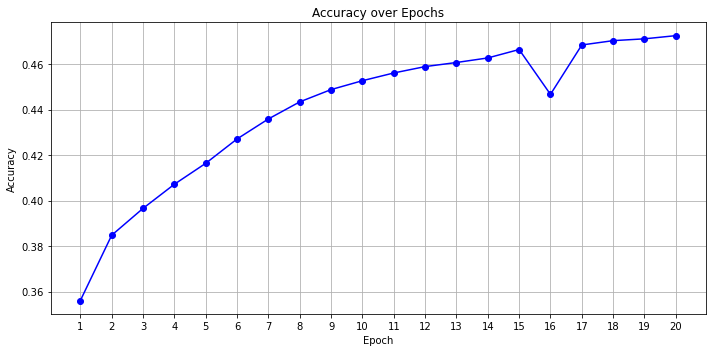

In [3]:
# Manually input the accuracy per epoch from the image
accuracy = [
    0.3561, 0.3848, 0.3966, 0.4072, 0.4164, 0.4271,
    0.4359, 0.4434, 0.4488, 0.4527, 0.4561, 0.4589,
    0.4607, 0.4627, 0.4664, 0.4467, 0.4684, 0.4703,
    0.4711, 0.4725
]

# Epochs are simply 1 to 20
epochs = list(range(1, 21))

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, marker='o', linestyle='-', color='b')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()

# Save the plot to a file
plt.savefig('accuracy_over_epochs.png')

# Show the plot
plt.show()

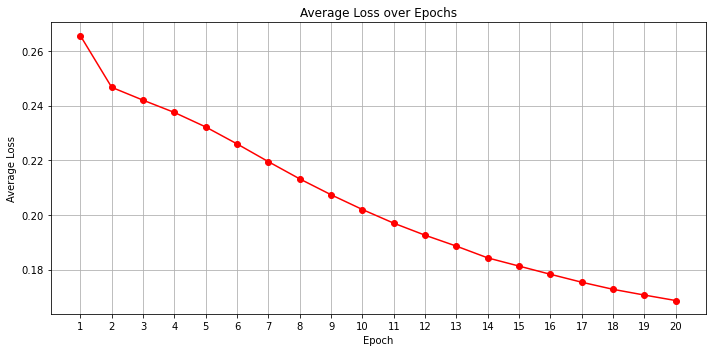

In [5]:
# Manually input the average loss per epoch from the image
avg_loss = [
    0.2656, 0.2467, 0.2420, 0.2375, 0.2322, 0.2260,
    0.2195, 0.2132, 0.2074, 0.2020, 0.1970, 0.1926,
    0.1886, 0.1843, 0.1813, 0.1783, 0.1754, 0.1728,
    0.1707, 0.1687
]

# Plotting the graph for average loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_loss, marker='o', linestyle='-', color='r')
plt.title('Average Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()

# Save the plot to a file
plt.savefig('avg_loss_over_epochs.png')

# Show the plot
plt.show()